# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Load Data
BASE = "/content/drive/MyDrive/satellite_property"

train_df = pd.read_excel(f"{BASE}/data/raw/train.xlsx")
test_df  = pd.read_excel(f"{BASE}/data/raw/test.xlsx")

print(train_df.shape, test_df.shape)


(16209, 21) (5404, 20)


In [4]:
# Separate Target Variable
TARGET = "price"

y = train_df[TARGET]
X = train_df.drop(columns=[TARGET])


#### **Correlation with Log Price**
The heatmap above illustrates the Pearson correlation coefficients of each feature with the logarithmically transformed target variable, `log_price`. This transformation helps normalize the target variable distribution and often improves model performance. Features with higher absolute correlation values are generally more influential in predicting house prices. 'grade' and 'sqft_living' show the strongest positive correlations, indicating that higher values in these features are associated with higher prices.

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   bedrooms       16209 non-null  int64  
 3   bathrooms      16209 non-null  float64
 4   sqft_living    16209 non-null  int64  
 5   sqft_lot       16209 non-null  int64  
 6   floors         16209 non-null  float64
 7   waterfront     16209 non-null  int64  
 8   view           16209 non-null  int64  
 9   condition      16209 non-null  int64  
 10  grade          16209 non-null  int64  
 11  sqft_above     16209 non-null  int64  
 12  sqft_basement  16209 non-null  int64  
 13  yr_built       16209 non-null  int64  
 14  yr_renovated   16209 non-null  int64  
 15  zipcode        16209 non-null  int64  
 16  lat            16209 non-null  float64
 17  long           16209 non-null  float64
 18  sqft_l

### Handling Missing Values

In [6]:
X.isnull().sum()


,0
id,0
date,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0
condition,0


In [7]:
y_log = np.log(y)


## Feature Selection (Remove Non-Predictive Columns)

In [8]:
DROP_COLS = ["id","date"]

X = X.drop(columns=DROP_COLS)
test_df = test_df.drop(columns=DROP_COLS)


###  Handling Ordinal Features Correctly
Ordinal features were retained in numeric form to preserve their inherent ordering.

In [9]:
ordinal_features = ["grade", "condition", "view"]
X[ordinal_features].describe()


,grade,condition,view
count,16209.000000,16209.000000,16209.000000
mean,7.652971,3.407860,0.234253
std,1.171050,0.651553,0.763152
min,1.000000,1.000000,0.000000
25%,7.000000,3.000000,0.000000
50%,7.000000,3.000000,0.000000
75%,8.000000,4.000000,0.000000
max,13.000000,5.000000,4.000000


# Feature Engineering
Ratio-based features capture structural composition of houses more effectively than absolute size metrics.
Relative size features capture neighborhood density effects, enabling the model to distinguish between isolated large homes and those embedded in high-value neighborhoods.

In [10]:
X["basement_ratio"] = X["sqft_basement"] / (X["sqft_living"] + 1)
X["above_ratio"] = X["sqft_above"] / (X["sqft_living"] + 1)

test_df["basement_ratio"] = test_df["sqft_basement"] / (test_df["sqft_living"] + 1)
test_df["above_ratio"] = test_df["sqft_above"] / (test_df["sqft_living"] + 1)


In [11]:
# Neighborhood Context Features
#House value depends on surroundings
#Relative size matters more than absolute size

X["relative_living_size"] = X["sqft_living"] / (X["sqft_living15"] + 1)
X["relative_lot_size"] = X["sqft_lot"] / (X["sqft_lot15"] + 1)

test_df["relative_living_size"] = test_df["sqft_living"] / (test_df["sqft_living15"] + 1)
test_df["relative_lot_size"] = test_df["sqft_lot"] / (test_df["sqft_lot15"] + 1)


### Scaling Numerical Features
Numerical features were standardized to zero mean and unit variance to ensure balanced optimization during model training

In [12]:
from sklearn.preprocessing import StandardScaler

scale_cols = X.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

X_scaled = X.copy()
test_scaled = test_df.copy()

X_scaled[scale_cols] = scaler.fit_transform(X[scale_cols])
test_scaled[scale_cols] = scaler.transform(test_df[scale_cols])


In [13]:
X_scaled.shape, test_scaled.shape


((16209, 22), (5404, 22))

# Feature Selection


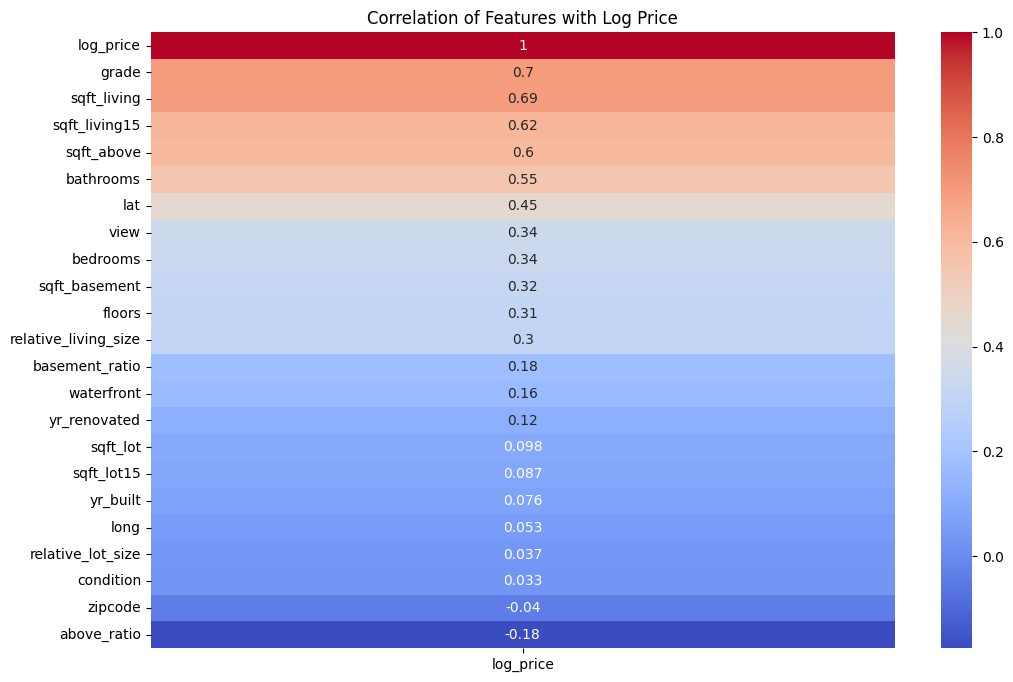

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features + target for analysis
corr_df = X_scaled.copy()
corr_df["log_price"] = y_log

plt.figure(figsize=(12,8))
sns.heatmap(
    corr_df.corr()[["log_price"]].sort_values("log_price", ascending=False),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation of Features with Log Price")
plt.show()
